### Business Case 2 - Extra Trees Script

This script continues from the model selection script. In this script we will pick the H2 dated and design a predictive algorithm with the ExtraTreesClassifier algorithm.

In particular, this script will use  perform model optimization in order to improve performance the algorithms predictive capabilities.

In [1]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time
import plotly.express as px

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer,PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering , KMeans, DBSCAN


#!{sys.executable} -m pip install lightgbm
from lightgbm import LGBMModel,LGBMClassifier

#!{sys.executable} -m pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.datasets import make_classification, load_digits
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve


In [2]:
#imports dataframes

dataframe = pd.read_csv("H2.csv")
dataframe.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


##  Stage: Data Preparation

Repeat of previous data manipulations.

In [7]:
#in total, there seem to be very few missing value
#features whose expected values are numeric look to be numeric. 
#some numeric and object variables may be converted to date-time

dataframe['Country'].fillna('NULL', inplace = True)
dataframe['Children'].fillna(np.mean(dataframe['Children']), inplace = True)

In [11]:
# Organizar features
target = ['IsCanceled']

numeric_feat = ['LeadTime','ArrivalDateYear','ArrivalDateWeekNumber','ArrivalDateDayOfMonth',
           'StaysInWeekendNights','StaysInWeekNights','Adults','Children','Babies',
           'PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges',
          'Agent','Company','DaysInWaitingList','ADR','RequiredCarParkingSpaces',
          'TotalOfSpecialRequests']

binary_feat = ['IsRepeatedGuest']

categorical_feat = ['ArrivalDateMonth','Meal','Country','MarketSegment','DistributionChannel','ReservedRoomType',
               'AssignedRoomType','DepositType','CustomerType','ReservationStatus']

date = ['ReservationStatusDate']

## Functions to Call later

In [19]:
#ENCODERS
def encode_categorical(dataset):
    encoded_df = dataset.copy()

    #months
    months = {'January':1,'February':2,'March':3,'April':4,'May':5,
             'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    encoded_df['ArrivalDateMonth'] = encoded_df['ArrivalDateMonth'].map(months)
    
    #countries
    other_countries = list(filter(lambda w: w not in ['PRT','ITA','GBR','FRA','DEU','ESP'], list(encoded_df['Country'].unique())))
    encoded_df['Country'] = encoded_df['Country'].replace(other_countries,'Other')
    countries = {'PRT':1,'FRA':2,'DEU':3,'GBR':4,'ESP':5,'ITA':6,'Other':7}
    encoded_df['Country'] = encoded_df['Country'].map(countries)
    
    #To one-hot
    list_to_dummify =['Meal','DepositType','CustomerType','MarketSegment']
    
    dummies = pd.get_dummies(encoded_df[list_to_dummify])
    encoded_df = encoded_df.join(dummies)
    encoded_df.drop(columns = list_to_dummify,axis=1,inplace=True)
    
    #ordinal    
    #confirmar agent e company
    enc = OrdinalEncoder()
    to_encode = ["ReservedRoomType","AssignedRoomType",'DistributionChannel']
    encoded_df[to_encode] = enc.fit_transform(encoded_df[to_encode])
        
        
        
        
    return encoded_df

In [20]:
def feature_selection_table(dataset):

    feature_df = dataset.copy()

    X = feature_df.drop(['IsCanceled'],axis=1)
    y = feature_df['IsCanceled']
    num_feats=len(X.columns)
    X_norm = MinMaxScaler().fit_transform(X)

    #RFE
    rfe_selector = RFE(estimator=DecisionTreeClassifier(), step=2)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()

    #RFECV
    rfecv_selector = RFECV(estimator=DecisionTreeClassifier(), step=3, cv=5, scoring='f1_weighted')
    rfecv_selector = rfecv_selector.fit(X_norm, y)
    rfecv_support = rfecv_selector.support_
    rfecv_feature = X.loc[:,rfecv_support].columns.tolist()

    #Logistic regression
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

    #RandomForest 
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


    #LGBMClassifier
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

    #Lasso
    reg = LassoCV(random_state=123) 
    reg.fit(X=X,y=y)
    lasso_coef = pd.Series(reg.coef_,index = X.columns)

    #Ridge
    ridge = RidgeCV()
    ridge.fit(X=X,y=y)
    coef_ridge = pd.Series(ridge.coef_,index = X.columns)

    #Elastic 
    elast = ElasticNetCV(cv=5, random_state=123)
    elast.fit(X, y)
    elast_coef = pd.Series(elast.coef_,index = X.columns)

    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':X.columns, 'RFE':rfe_support,'RFECV':rfecv_support, 'Logistics':embeded_lr_support,
                                        'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'Lasso':lasso_coef != 0, 'Ridge':coef_ridge != 0, 'Elastic':elast_coef != 0})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total'] , ascending=False)
    feature_selection_df.set_index('Feature',inplace=True)
    feature_selection_df
    
    return feature_df,feature_selection_df

In [21]:
def normalize(dataset,scaler):
    
    if scaler == 'MinMax':
        pt = MinMaxScaler()
    elif scaler == 'Standard':
        pt = StandardScaler()
    elif scaler == 'Robust':
        pt = RobustScaler()
    elif scaler == 'Quantile':
        pt = QuantileTransformer()
    else:
        pt = PowerTransformer(method='yeo-johnson')
    
    data = pt.fit_transform(dataset)
    
    # convert the array back to a dataframe
    normalized_df = pd.DataFrame(data,columns=dataset.columns)
    return normalized_df

# Starting data preparation:


## Start by Calling the Funtions

In [22]:
#Dropping non relevant features

data_prep_df = dataframe.drop(columns =['ReservationStatus','ReservationStatusDate','ArrivalDateYear'])
#data_prep_df['Agent'] = data_prep_df['Agent'].replace(NULL,0)
data_prep_df['Company'] = data_prep_df['Company'].str.replace('NULL','0').astype(int)
data_prep_df['Agent'] = data_prep_df['Agent'].str.replace('NULL','0').astype(int)

In [23]:
X = data_prep_df.drop(['IsCanceled'],axis=1)
y = data_prep_df['IsCanceled']

In [24]:
encoded_df = encode_categorical(data_prep_df)

In [25]:
feature_df,feature_selection_df = feature_selection_table(encoded_df)
feature_selection_df

,RFE,RFECV,Logistics,Random Forest,LightGBM,Lasso,Ridge,Elastic,Total
Feature,,,,,,,,,
LeadTime,True,True,True,True,True,True,True,True,8
TotalOfSpecialRequests,True,True,True,True,True,True,True,True,8
StaysInWeekNights,True,True,True,True,True,True,True,True,8
ADR,True,True,True,True,True,True,True,True,8
ArrivalDateWeekNumber,True,True,False,True,True,True,True,True,7
Agent,True,True,False,True,True,True,True,True,7
ReservedRoomType,True,True,True,False,True,True,True,True,7
DepositType_No Deposit,True,True,True,True,False,True,True,True,7
BookingChanges,True,True,True,False,False,True,True,True,6


In [26]:
final_feature_dataset = feature_df[feature_selection_df.loc[feature_selection_df['Total'] >3].index.tolist()]
#general normalization
normalized_dataset = normalize(final_feature_dataset,'Quantile')

In [27]:
X = normalized_dataset

In [28]:
X

,LeadTime,TotalOfSpecialRequests,StaysInWeekNights,ADR,ArrivalDateWeekNumber,Agent,ReservedRoomType,DepositType_No Deposit,BookingChanges,AssignedRoomType,...,MarketSegment_Online TA,ArrivalDateDayOfMonth,ArrivalDateMonth,CustomerType_Transient,CustomerType_Transient-Party,RequiredCarParkingSpaces,DaysInWaitingList,Adults,StaysInWeekendNights,PreviousBookingsNotCanceled
0,0.121121,0.000000,0.494995,0.000000,0.493493,0.228729,0.000000,1.0,0.0,0.000000,...,0.0,0.000000,0.540040,1.0,0.0,0.0,0.0,0.104605,0.000000,0.0
1,0.549049,0.739239,0.906406,0.227227,0.493493,0.507007,0.000000,1.0,0.0,0.000000,...,1.0,0.000000,0.540040,1.0,0.0,0.0,0.0,0.572072,0.000000,0.0
2,0.461962,0.739239,0.906406,0.147147,0.493493,0.507007,0.000000,1.0,0.0,0.000000,...,1.0,0.000000,0.540040,1.0,0.0,0.0,0.0,0.104605,0.000000,0.0
3,0.562062,0.925926,0.906406,0.227227,0.493493,0.507007,0.000000,1.0,0.0,0.000000,...,1.0,0.000000,0.540040,1.0,0.0,0.0,0.0,0.572072,0.868869,0.0
4,0.589590,0.739239,0.494995,0.227227,0.493493,0.507007,0.000000,1.0,0.0,0.000000,...,1.0,0.046046,0.540040,1.0,0.0,0.0,0.0,0.572072,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0.251251,0.000000,0.965966,0.462930,0.686687,0.997998,0.000000,1.0,0.0,0.000000,...,0.0,0.967968,0.647648,1.0,0.0,0.0,0.0,0.572072,0.868869,0.0
79326,0.596597,0.925926,0.965966,0.989132,0.686687,0.507007,0.961461,1.0,0.0,0.948448,...,1.0,1.000000,0.647648,1.0,0.0,0.0,0.0,0.969469,0.868869,0.0
79327,0.315315,0.998498,0.965966,0.903323,0.686687,0.507007,0.877377,1.0,0.0,0.840340,...,1.0,1.000000,0.647648,1.0,0.0,0.0,0.0,0.572072,0.868869,0.0
79328,0.617618,0.000000,0.965966,0.551051,0.686687,0.929930,0.000000,1.0,0.0,0.000000,...,1.0,1.000000,0.647648,1.0,0.0,0.0,0.0,0.572072,0.868869,0.0


# MODEL TESTING

We will make a split between between train and test. As we will use cross validation (repeated_Stratified_k_fold)

## Test 1: SMOTE


In [29]:
#train_test_split to get 20% of data as test

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                  y,
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y)

In [30]:
##aplication of smote to balance dataset for training, even though

from imblearn.over_sampling import SMOTE
from collections import Counter

over = SMOTE()
X_train_val, y_train_val = over.fit_resample(X_train_val, y_train_val)


print(sorted(Counter(y_train_val).items()))

[(0, 36982), (1, 36982)]


In [31]:
#run desired model
def run_model(model_name, X, y):
    ### runs model with a predetermined configuration
    if model_name == 'ExtraTree':
        model = ExtraTreesClassifier(n_estimators=175, criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y)
    return model

In [32]:
def avg_score(method,X,y, model_name):
    #averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'ExtraTree':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [33]:
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test):
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (20, 10))

    #sets style of the plot to increase readibility
    sns.set_style(style="whitegrid")

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6

    #makes the plot
    plt.bar(pos_train, f1micro_train, color='dodgerblue', width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color='steelblue', width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color='skyblue', width=barwidth, edgecolor='white', label='Test')

    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')

    #personalizes yticks to inrease readibility of data in the plot
    ax.set_yticks(np.arange(0, 1, 0.1))

    #ads title to the plot
    plt.title('10-fold Repeated Cross-Validation Results', fontsize = 14)

    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)

    #shows plot
    plt.show()

In [34]:
def plot_roc_pr(models, X, y):  
    sns.set_style(style="whitegrid")
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC Curve Test')
    plt.legend(loc="lower right", frameon=False)
    plt.show()

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)')
    plt.ylabel('Precision (True Positive Rate)')
    plt.title('Precision-Recall Curve Test')
    plt.legend(loc="lower left", frameon=False)
    plt.show()

In [35]:
method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 15)

results_Xtra = avg_score(method_cv, X_train_val, y_train_val, 'ExtraTree')

In [36]:
results_models = [results_Xtra]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['ExtraTree'])

print('Averaged Confusion Matrix for XtraTree:\n', results_models[0][10])

df 

Averaged Confusion Matrix for XtraTree:
 [[3358.23  339.97]
 [ 833.81 2864.39]]


,ExtraTree
Train Accuracy (F1 Score micro),0.847+/-0.001
Validation Accuracy (F1 Score micro),0.841+/-0.0
Test Accuracy (F1 Score micro),0.847
Precision Train,0.898+/-0.002
Precision Validation,0.894+/-0.005
Precision Test,0.85
Recall Train,0.782+/-0.002
Recall Validation,0.775+/-0.007
Recall Test,0.77
Time,4.785+/-0.143


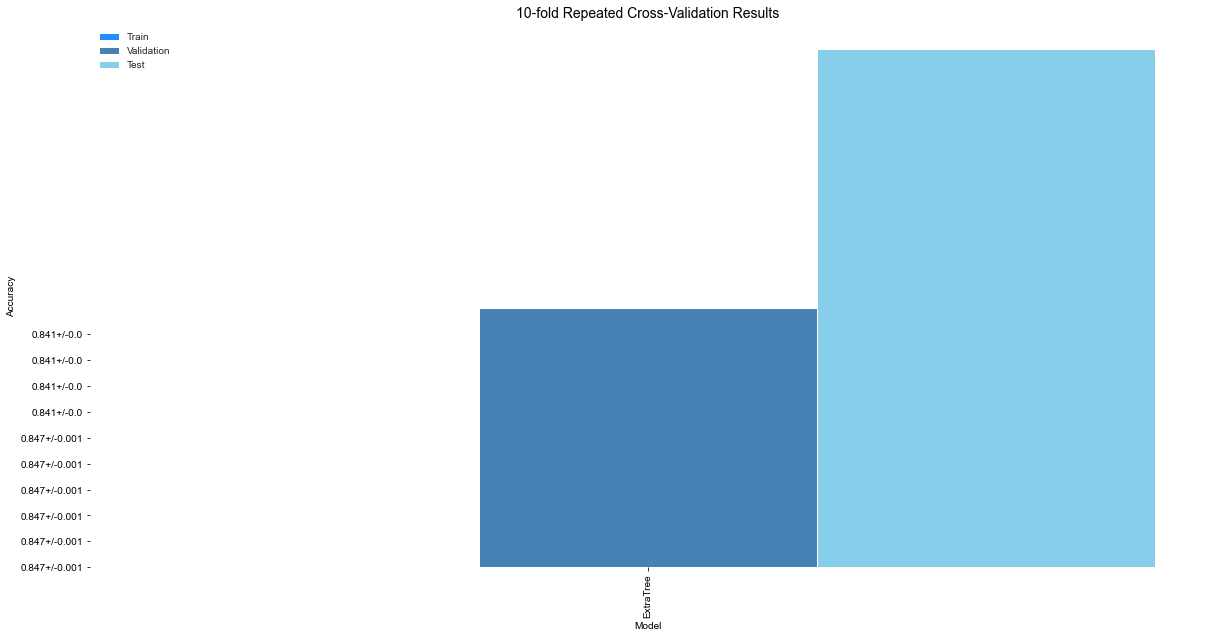

In [37]:
models = ['ExtraTree']

plt_bar(models, f1micro_train, f1micro_val, f1micro_test)

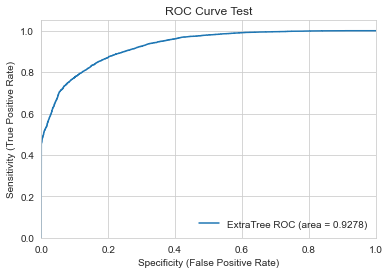

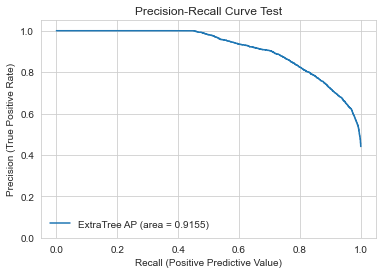

In [38]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'ExtraTree', 'model': run_model('ExtraTree', X_train_val, y_train_val),}]

plot_roc_pr(models, X_test, y_test)

We finish by understanding that ExtraTrees Classifiers looks to be most suitable model. In the next Notebook, we will look to optimize our ExtraTrees Classification.

In [39]:
#Benchmark Predicition on Test Data - 0.846

#now running different tests

In [43]:
model = ExtraTreesClassifier(n_estimators=100,criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y)
                            
gsc = GridSearchCV(
    
    estimator=model,
    param_grid={
        'n_estimators': range(50,401,50),
        'min_samples_leaf': range(10,51,20),
        'min_samples_split': range(15,56,10),
        'criterion': ['gini', 'entropy'],
        'max_depth':  range(5, 46, 10),
        'random_state': [15],
        
    },
    cv= 5,
    verbose = 2
)

grid_result = gsc.fit(X_train_val, y_train_val)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

for test_mean, train_mean, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['mean_train_score'],
        grid_result.cv_results_['params']):
    print("Train: %f // Test : %f with: %r" % (train_mean, test_mean, param))


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf

[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15, total=   6.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sample

[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15, total=   5.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15, total=   5.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15, total=   5.7s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15, total=   5.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   4.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   4.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   3.9s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sample

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   0.8s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samp

[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  11.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  11.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  10.9s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  11.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15, total=   2.9s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15, total=   2.9s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samp

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15, total=  11.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15, total=  11.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15, total=  11.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15, total=  12.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=  10.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=  10.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=  10.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=  10.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   8.4s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   8.4s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   7.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   7.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   4.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   4.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   4.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=  14.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   2.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   1.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   1.9s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=15, min_sam

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=  10.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15, total=  11.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15, total=  12.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15, total=  11.5s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   8.8s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15, total=  11.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15, total=  11.4s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15, total=   9.9s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=15, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   9.2s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15, total=  10.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15, total=  11.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15, total=  11.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   6.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15, total=   8.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15, total=   8.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15, total=   8.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   5.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15, total=   7.2s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15, total=   6.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15, total=   6.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15, total=   3.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15, total=   5.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15, total=   4.9s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15, total=   5.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15, total=   1.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, m

[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15, total=  12.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15, total=  12.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_s

[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15, total=  10.2s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15, total=  10.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  12.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  13.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15, total=  10.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15, total=   9.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15, total=  11.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15, total=  11.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   8.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   8.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15, total=   9.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15, total=   9.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15, total=   8.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15, total=   7.8s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.9s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=150, random_state=15, total=   4.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15, total=   3.2s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=25, min

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=  11.4s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=  11.3s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15, total=   1.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15, total=   1.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=25, min_s

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15, total=  10.7s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15, total=  10.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=  11.5s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=  11.8s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=  10.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   9.9s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15, total=   7.1s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   8.8s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=25, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15, total=   7.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   9.0s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   9.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   5.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   5.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   7.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   3.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   3.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   5.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15, total=   3.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15, total=   3.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  14.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  14.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15, total=   1.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15, total=   1.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_s

[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  12.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  12.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15, total=  14.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15, total=  13.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   9.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   9.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15, total=  11.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15, total=  11.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   8.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15, total=  10.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15, total=   9.9s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   6.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   6.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   8.0s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   8.0s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15, total=   4.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15, total=   4.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   6.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=35, min

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15, total=   9.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15, total=   9.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=35, min_s

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=   8.5s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=   8.6s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=   9.9s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=   9.7s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   7.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15, total=   8.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15, total=   8.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15, total=   7.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15, total=   7.4s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15, total=   6.3s
[CV] criterion=gini, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=35, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   4.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   4.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15, total=   2.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   3.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=400, random_state=15, total=  16.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=400, random_state=15, total=  17.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   2.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   2.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_s

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=350, random_state=15, total=  14.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=350, random_state=15, total=  14.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  16.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  16.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=300, random_state=15, total=  11.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=300, random_state=15, total=  11.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  14.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  13.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15, total=   8.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15, total=   8.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   9.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   9.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   6.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   7.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   7.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   4.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   4.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   3.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   3.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15, total=   5.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15, total=   5.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   2.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   2.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15, total=   3.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15, total=   3.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=gini, max_depth=45, min

[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  15.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  15.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15, total=   1.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15, total=   1.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=gini, max_depth=45, min_s

[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=  13.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=  13.1s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15, total=  15.0s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15, total=  14.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15, total=   9.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15, total=   9.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=  11.2s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=  10.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15, total=   7.5s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   8.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   8.7s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=200, random_state=15, total=   5.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=200, random_state=15, total=   5.9s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   7.3s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=150, random_state=15, total=   4.4s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=150, random_state=15, total=   4.4s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.8s
[CV] criterion=gini, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=gini, max_depth=45, 

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   2.1s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, ma

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=   6.1s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=   5.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=   5.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=   5.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=300, random_state=15, total=   4.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   3.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   4.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   4.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   2.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   2.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=25, n_estimators=400, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, ma

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=   4.8s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=350, random_state=15, total=   4.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=   5.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   3.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   3.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   3.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   3.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   3.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=100, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   2.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   0.7s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   4.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   4.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   4.9s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   4.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entr

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=200, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  10.9s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  10.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  10.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  10.9s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=300, random_state=15, total=   8.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=   9.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=   9.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=   9.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15, total=   6.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=250, random_state=15, total=   6.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   7.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   7.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   5.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   6.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   3.9s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   3.9s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=45, n_estimators=400, random_state=15, total=  10.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=350, random_state=15, total=   8.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=350, random_state=15, total=   9.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  10.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  10.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15, total=   7.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15, total=   7.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15, total=   7.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=   8.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=50, random_state=15, total=   1.2s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   9.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=   9.8s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=  10.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  10.7s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  10.8s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  10.7s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=350, random_state=15, total=  10.9s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15, total=   9.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=10, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15, total=  10.8s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=15, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=300, random_state=15, total=   8.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15, total=   9.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15, total=   9.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15, total=   9.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   6.7s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=250, random_state=15, total=   6.7s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15, total=   8.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15, total=   8.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   5.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=200, random_state=15, total=   5.5s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15, total=   6.8s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=150, random_state=15, total=   4.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=100, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=15, n_estimators=400, random_state=15, total=  10.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=   9.0s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=350, random_state=15, total=   8.8s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=  10.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15, total=  10.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   7.7s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=300, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15, total=   9.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.4s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=250, random_state=15, total=   6.6s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15, total=   5.3s
[CV] criterion=entropy, max_depth=25, min_samples_leaf=50, min_samples_split=55, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   4.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=  12.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=  12.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=25, n_estimators=400, random_state=15, total=  12.5s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=  10.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=  10.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=  10.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=350, random_state=15, total=  10.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   9.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   8.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   8.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15, total=   8.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=45, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=200, random_state=15, total=   6.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15, total=   7.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15, total=   7.5s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15, total=   7.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=10, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   4.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=150, random_state=15, total=   4.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15, total=   6.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15, total=   6.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   2.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=100, random_state=15, total=   3.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=150, random_state=15, total=   4.4s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=  12.4s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=  12.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=  12.1s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=35, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=300, random_state=15, total=   8.4s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   9.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   9.8s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15, total=   9.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=250, random_state=15, total=   6.8s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   8.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15, total=   8.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=30, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=200, random_state=15, total=   5.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15, total=   6.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   4.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   3.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   3.9s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=100, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=35, n_estimators=400, random_state=15, total=  10.2s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15, total=   1.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   9.0s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=350, random_state=15, total=   9.1s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15, total=  10.5s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15, total=  10.4s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   7.7s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   7.8s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=300, random_state=15, total=   7.8s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15, total=   9.3s
[CV] criterion=entropy, max_depth=35, min_samples_leaf=50, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   8.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.9s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=15, total=   7.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   6.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   6.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=25, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   4.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15, total=   4.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=50, random_state=15, total=   1.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15, total=   3.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  12.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  12.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=45, n_estimators=400, random_state=15, total=  12.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15, total=   1.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  10.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  10.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  10.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=350, random_state=15, total=  10.4s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=10, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   8.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   8.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   8.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15, total=   8.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=15, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=200, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   6.9s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15, total=   7.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=150, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   5.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15, total=   5.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.7s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=100, random_state=15, total=   2.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15, total=   4.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=50, random_state=15, total=   1.4s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  10.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  11.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15, total=  11.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=30, min_samples_split=55, n_estimators=400, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=300, random_state=15, total=   7.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=   9.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=   9.2s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15, total=   9.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=15, n_estimators=350, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=250, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15, total=   7.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15, total=   7.5s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=25, n_estimators=300, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.1s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=200, random_state=15, total=   5.0s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15, total=   6.3s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=35, n_estimators=250, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.7s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=150, random_state=15, total=   3.8s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=45, n_estimators=200, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15, total=   2.6s
[CV] criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=100, random_state=15 
[CV]  criter

[CV]  criterion=entropy, max_depth=45, min_samples_leaf=50, min_samples_split=55, n_estimators=400, random_state=15, total=  10.5s


[Parallel(n_jobs=1)]: Done 6000 out of 6000 | elapsed: 599.9min finished


Best: 0.860527 using {'criterion': 'gini', 'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 150, 'random_state': 15}


KeyError: 'mean_train_score'

In [56]:
print("Best parameters set found on development set:")
print()
print(gsc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gsc.cv_results_['mean_test_score']
stds = gsc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 150, 'random_state': 15}

Grid scores on development set:

0.795 (+/-0.009) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 50, 'random_state': 15}
0.794 (+/-0.010) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 100, 'random_state': 15}
0.796 (+/-0.010) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 150, 'random_state': 15}
0.795 (+/-0.009) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 200, 'random_state': 15}
0.795 (+/-0.010) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 250, 'random_state': 15}
0.794 (+/-0.010) for {'criterion': 'gini', 'ma

In [59]:
#Prediction
    
model = ExtraTreesClassifier(**grid_result.best_params_)

model.fit(X_train_val, y_train_val)

predicted_test = model.predict(X_test)
final_prediction = pd.DataFrame(index= y_test.index)
final_prediction['Prediction'] = predicted_test
final_prediction['Real'] = y_test

final_prediction

,Prediction,Real
4202,0,0
17168,1,1
21864,1,1
19616,1,1
13034,1,1
...,...,...
23434,1,1
17064,1,1
23508,0,1
30927,1,1


In [61]:
print(classification_report(y_test, predicted_test))
print(confusion_matrix(y_test, predicted_test))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      9246
           1       0.87      0.80      0.83      6620

    accuracy                           0.87     15866
   macro avg       0.87      0.86      0.86     15866
weighted avg       0.87      0.87      0.86     15866

[[8434  812]
 [1324 5296]]


In [68]:
Best: {'criterion': 'gini', 'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 150, 'random_state': 15}

## Preparing for final model - running it in order to get ROC and Precision Recall Curves

In [92]:
#run desired model
def run_final_model(X, y):
    '''runs Extra trees with with best params* result'''
    model = ExtraTreesClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf = 10, min_samples_split = 15, n_estimators = 150, random_state = 15).fit(X, y)
    
    return model

In [98]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_final_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_final_model(X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'ExtraTree':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_final_model(X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [99]:
method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 15)

results_final_Xtra = avg_final_score(method_cv, X_train_val, y_train_val, 'ExtraTree')

In [100]:
results_models = [results_final_Xtra]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['ExtraTree'])

print('Averaged Confusion Matrix for XtraTree:\n', results_models[0][10])

df 

Averaged Confusion Matrix for XtraTree:
 [[3380.6   317.6 ]
 [ 697.95 3000.25]]


,ExtraTree
Train Accuracy (F1 Score micro),0.878+/-0.001
Validation Accuracy (F1 Score micro),0.863+/-0.0
Test Accuracy (F1 Score micro),0.864
Precision Train,0.916+/-0.001
Precision Validation,0.904+/-0.005
Precision Test,0.867
Recall Train,0.831+/-0.002
Recall Validation,0.811+/-0.007
Recall Test,0.797
Time,6.712+/-0.297


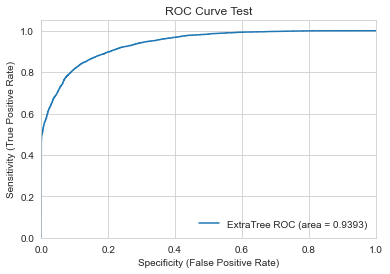

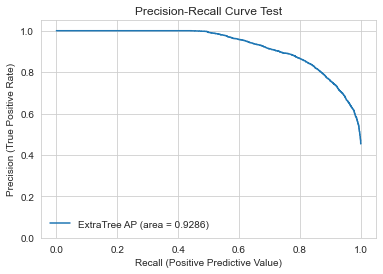

In [101]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'ExtraTree', 'model': run_final_model(X_train_val, y_train_val),}]

plot_roc_pr(models, X_test, y_test)

Model configutation to be exported to a third script. That script will be used as the base for the predictive app.